# Topic Modeling (LDA Model) Code

## Model Implementation

1. Loading Data
2. Data Cleaning and exploratory data analysis
3. Phrase Modeling: Bi-grams and Tri-grams
4. Data Transformation: Corpus and Dictionary
5. Base Model
6. Model Evaluation
7. Finding optimal number of topics
8. Visualise results with pyLDAvis
9. Finding dominant topics for each document

In [37]:
# Standard dataframe packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Text analytics packages
import gensim
import nltk
from sklearn.feature_extraction.text import CountVectorizer

# Object serialization package
import pickle

C:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1. Loading Data

In [2]:
# Read data

data = pd.read_excel("billsum_test.xlsx")

# Print head
data.head()

,contract,content,summary
0,To amend the Internal Revenue Code of 1986 to ...,SECTION 1. SHORT TITLE. This Act may be cited ...,National Science Education Tax Incentive for B...
1,To amend the Internal Revenue Code of 1986 to ...,SECTION 1. SHORT TITLE. This Act may be cited ...,Small Business Expansion and Hiring Act of 201...
2,A bill to require the Director of National Int...,SECTION 1. RELEASE OF DOCUMENTS CAPTURED IN IR...,Requires the Director of National Intelligence...
3,A bill to improve data collection and dissemin...,SECTION 1. SHORT TITLE. This Act may be cited ...,National Cancer Act of 2003 - Amends the Publi...
4,A bill to amend the Internal Revenue Code of 1...,SECTION 1. SHORT TITLE. This Act may be cited ...,Military Call-up Relief Act - Amends the Inter...


### 2. Data Cleaning and exploratory data analysis

In [3]:
#See all column names
data.info()
    


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   contract  3269 non-null   object
 1   content   3269 non-null   object
 2   summary   3269 non-null   object
dtypes: object(3)
memory usage: 76.7+ KB


In [3]:
# Only take in relevant column
data_text = pd.DataFrame()
data_text["Text"] = data["content"]

# Print out the first few rows of Billsum dataset
data_text.head()

,Text
0,SECTION 1. SHORT TITLE. This Act may be cited ...
1,SECTION 1. SHORT TITLE. This Act may be cited ...
2,SECTION 1. RELEASE OF DOCUMENTS CAPTURED IN IR...
3,SECTION 1. SHORT TITLE. This Act may be cited ...
4,SECTION 1. SHORT TITLE. This Act may be cited ...


In [4]:
# Load the regular expression library
import re

# Remove punctuation
data_text["Text_Processed"] = data_text["Text"].map(lambda x: re.sub('[,\.!?]', '', x))

#remove numbers and space
def remove_space(df):
    df = df.replace(r'\n',' ', regex=True)
    df = df.replace(r'\n\n',' ', regex=True)
    df = df.replace(r'\\n',' ', regex=True)
    df = df.replace('\s+', ' ', regex=True)
    df=df.apply(lambda x: re.sub('[0-9.,\\()/:]+', '', x))
    return df

data_text['Text_Processed']=remove_space(data_text['Text_Processed'])

# Convert the titles to lowercase
data_text["Text_Processed"] = data_text["Text_Processed"].map(lambda x: x.lower())

# Print out the first rows of data_text
data_text["Text_Processed"].head()

0    section  short title this act may be cited as ...
1    section  short title this act may be cited as ...
2    section  release of documents captured in iraq...
3    section  short title this act may be cited as ...
4    section  short title this act may be cited as ...
Name: Text_Processed, dtype: object

### 3. Phrase Modeling: Bi-grams and Tri-grams

In [5]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = data_text["Text_Processed"].values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['section', 'short', 'title', 'this', 'act', 'may', 'be', 'cited', 'as', 'the', 'national', 'science', 'education', 'tax', 'incentive', 'for', 'businesses', 'act', 'of', 'sec', 'credits', 'for', 'certain', 'contributions', 'benefiting', 'science', 'technology', 'engineering', 'and', 'mathematics']


Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Gensim's Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold.

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#### Continuation of data cleaning: Remove Stopwords, Make Bigrams and Lemmatize

In [7]:
# NLTK Stop words
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

#ADD RELEVANT STOP WORDS
stop_words.extend(['act','use','section','short'])
#stop_words.extend(['agreement','contract','inc','user','exhibit','licensed','statement','page', 'licensee','licensor','fund','member','distributor','agree','agrees'])

In [9]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['title', 'cite', 'national', 'science', 'education', 'tax', 'incentive', 'business', 'credit', 'certain', 'contribution', 'benefit', 'science', 'technology_engineere', 'mathematic', 'education', 'elementary', 'level', 'general', 'subpart', 'part', 'iv', 'subchapter', 'chapter', 'internal_revenue', 'code', 'relate', 'business', 'relate', 'credit']


In [10]:
len(data_lemmatized)

3269

### 4. Data Transformation: Corpus and Dictionary

We use Gensim package for topic modelling. The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [11]:
import gensim.corpora as corpora

# Create Dictionary where it assigns an integer id to each unique word in the corpus
id2word = corpora.Dictionary(data_lemmatized)

#set parameters to filter the vocab based on frequency
#Filter out words that occur in less than 70 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=70, no_above=0.5) 
print('Total Vocabulary Size after filtering:', len(id2word))

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])


Total Vocabulary Size: 1625
[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 9), (6, 2), (7, 1), (8, 1), (9, 2), (10, 4), (11, 5), (12, 1), (13, 3), (14, 1), (15, 1), (16, 1), (17, 19), (18, 1), (19, 2), (20, 5), (21, 3), (22, 5), (23, 1), (24, 4), (25, 1), (26, 1), (27, 12), (28, 2), (29, 1)]


### 5. Base Model

We have everything required to train the base LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior (we'll use default for the base model).

chunksize controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.

passes controls how often we train the model on the entire corpus (set to 25). Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.

The above LDA model is built with 7 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics()

In [12]:
import random

random.seed(1) #it will keep printing the same number
print(random.randint(0,9))

2


In [13]:

num_topics = 7

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=0,
                                           chunksize=100,
                                           passes=25)
                                           

In [14]:
from pprint import pprint

# Print the Keyword in the set number of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
#topics:
#1. About employment, employee - may be related to sth about violation of laws about employment - topic 5
#2. about tax and loans on employee, employer (taxpayer)-topic 4
#3. about payment/information such as commission fee, costs, regulations regarding products, transportation - topic3
#4. about healthcare treatment, health plan, medical drugs - topic6
#5. about government office, committee regarding national policies such as security, defense/military, aliens - topic2
#6. about environmental conservation such as energy, land conservation -topic7
#7. about grants, funding for the development of education, research and technology 

[(0,
  '0.028*"person" + 0.014*"individual" + 0.014*"action" + 0.012*"employee" + '
  '0.012*"claim" + 0.012*"court" + 0.011*"violation" + 0.009*"agency" + '
  '0.008*"right" + 0.008*"information"'),
 (1,
  '0.026*"credit" + 0.020*"qualified" + 0.016*"individual" + 0.016*"tax" + '
  '0.013*"pay" + 0.012*"percent" + 0.012*"taxpayer" + 0.012*"striking" + '
  '0.012*"case" + 0.011*"account"'),
 (2,
  '0.014*"information" + 0.011*"regulation" + 0.010*"standard" + '
  '0.010*"product" + 0.010*"consumer" + 0.009*"agency" + 0.008*"administrator" '
  '+ 0.008*"loan" + 0.008*"security" + 0.007*"issue"'),
 (3,
  '0.030*"insert" + 0.029*"health" + 0.029*"plan" + 0.023*"individual" + '
  '0.019*"strike" + 0.018*"striking" + 0.015*"benefit" + 0.014*"drug" + '
  '0.014*"care" + 0.014*"payment"'),
 (4,
  '0.025*"member" + 0.017*"commission" + 0.015*"government" + 0.013*"office" + '
  '0.012*"committee" + 0.010*"representative" + 0.009*"department" + '
  '0.009*"security" + 0.009*"appoint" + 0.009*"co

The topics produced from the model are:
1. About employment, employee - may be related to sth about violation of laws about employment
2. About tax and loans on employee, employer (taxpayer)
3. About payment/information such as commission fee, costs, regulations regarding products, transportation
4. About healthcare treatment, health plan, medical drugs
5. About government office, committee regarding national policies such as security, defense/military, aliens
6. About environmental conservation such as energy, land conservation
7. About grants, funding for the development of education, research and technology

In [34]:
#another way to present the topics
topics = lda_model.show_topics(formatted=False)
topics

C:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  [('person', 0.028555239),
   ('information', 0.014889119),
   ('action', 0.013583736),
   ('court', 0.011208789),
   ('individual', 0.011072345),
   ('violation', 0.010562828),
   ('agency', 0.009523769),
   ('claim', 0.009324864),
   ('employee', 0.008613852),
   ('right', 0.0074867522)]),
 (1,
  [('school', 0.029348722),
   ('student', 0.028355807),
   ('eligible', 0.027725795),
   ('education', 0.024554908),
   ('institution', 0.021841183),
   ('loan', 0.021679707),
   ('assistance', 0.021527804),
   ('grant', 0.018364994),
   ('educational', 0.015620118),
   ('individual', 0.015473411)]),
 (2,
  [('product', 0.011901613),
   ('consumer', 0.011315847),
   ('regulation', 0.010978654),
   ('standard', 0.009694807),
   ('facility', 0.008488847),
   ('issue', 0.008167429),
   ('security', 0.007848874),
   ('administrator', 0.007768771),
   ('fee', 0.0071353605),
   ('information', 0.00703514)]),
 (3,
  [('health', 0.0414774),
   ('plan', 0.031881813),
   ('individual', 0.02474782

### 6. Model Evaluation
#### Compute Model Perplexity and Coherence Score

Let's calculate the baseline coherence score and perplexity score

In [15]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.48868986316344004


In [16]:
log_perplexity = lda_model.log_perplexity(corpus)
perplexity = 2**(-log_perplexity)
print('Perplexity: ',perplexity)

Perplexity:  92.36048202624458


### 7. Finding the optimal number of topics

To find the optimal number of topics, we plot the number of topics (max of 40 topics) against the coherence score. Using the Elbow method, we are able to find the optimal number of topics. 

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

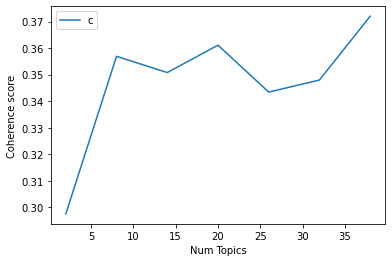

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Hence, the optimal number of topics is 7 as having 20 topics would be too many topics 

### 8. Visualise Results with pyLDAvis

In [55]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()


LDAvis_data_filepath = os.path.join('ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, 'ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

C:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.143421 -0.124490       1        1  21.178208
2      0.041050  0.040694       2        1  15.009897
4      0.098117  0.096209       3        1  14.988775
1     -0.252617 -0.021627       4        1  13.388127
0     -0.026728  0.178249       5        1  12.257078
3     -0.128904 -0.107188       6        1  12.030059
5      0.125662 -0.061848       7        1  11.147855, topic_info=           Term         Freq        Total Category  logprob  loglift
681        land  3848.000000  3848.000000  Default  30.0000  30.0000
299      health  5684.000000  5684.000000  Default  29.0000  29.0000
364     project  4420.000000  4420.000000  Default  28.0000  28.0000
20       credit  4085.000000  4085.000000  Default  27.0000  27.0000
72         plan  7183.000000  7183.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
197    activity   893.497371  4620.997751   Topic7  -4.9361   0.5507
18         cost   799.123835  3940.536550   Topic7  -5.0477   0.5984
0    accordance   687.998315  2397.038792   Topic7  -5.1975   0.9457
153   available   719.887606  3695.617664   Topic7  -5.1522   0.5581
652     subject   679.965082  3297.257082   Topic7  -5.2092   0.6151

[454 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
496       1  0.943145       academic
496       4  0.054902       academic
0         1  0.101375     accordance
0         2  0.154357     accordance
0         3  0.138087     accordance
...     ...       ...            ...
840       3  0.009103  years_beginne
840       4  0.227570  years_beginne
840       6  0.700917  years_beginne
1505      1  0.988357          youth
1505      6  0.007488          youth

[1568 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 5, 2, 1, 4, 6])

### 9. Finding dominant topics for each document 
We find the topic number that has the highest percentage contribution in that document.

In [16]:
# Keep the processed tokens as a sentence
sentences = []
for i in range(len(data_lemmatized)): 
    sentence = data_lemmatized[i]
    sentences.append(' '.join(sentence))



C:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=sentences):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

C:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=sentences)


C:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,1.0,0.5799,"credit, qualified, individual, tax, pay, perce...",title cite national science education tax ince...
1,1.0,0.9963,"credit, qualified, individual, tax, pay, perce...",title cite small_business expansion hire busin...
2,4.0,0.6027,"member, commission, government, office, commit...",release document capture make publicly_availab...
3,6.0,0.6811,"grant, fund, agency, fiscal_year, research, as...",title cite national cancer findings_congress m...
4,1.0,0.7841,"credit, qualified, individual, tax, pay, perce...",title cite military call relief waiver early w...
...,...,...,...,...
3264,6.0,0.8669,"grant, fund, agency, fiscal_year, research, as...",title cite congenital heart future reauthoriza...
3265,4.0,0.7040,"member, commission, government, office, commit...",title cite internal watchdog agency elevation ...
3266,3.0,0.9308,"insert, health, plan, individual, strike, stri...",title cite veteran eligibility reform veteran ...
3267,6.0,0.8238,"grant, fund, agency, fiscal_year, research, as...",teacher recruitment math science teacher recru...


In [25]:
# Format

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
#df_dominant_topic.to_csv('dominant_topics.csv')
df_dominant_topic.head(10)

C:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5799,"credit, qualified, individual, tax, pay, perce...",title cite national science education tax ince...
1,1,1.0,0.9963,"credit, qualified, individual, tax, pay, perce...",title cite small_business expansion hire busin...
2,2,4.0,0.6027,"member, commission, government, office, commit...",release document capture make publicly_availab...
3,3,6.0,0.6811,"grant, fund, agency, fiscal_year, research, as...",title cite national cancer findings_congress m...
4,4,1.0,0.7841,"credit, qualified, individual, tax, pay, perce...",title cite military call relief waiver early w...
5,5,2.0,0.7354,"information, regulation, standard, product, co...",reliquidation certain entry prematurely liquid...
6,6,3.0,0.5718,"insert, health, plan, individual, strike, stri...",title cite service dog veteran service dog tre...
7,7,6.0,0.9285,"grant, fund, agency, fiscal_year, research, as...",title cite race top top general title elementa...
8,8,6.0,0.4190,"grant, fund, agency, fiscal_year, research, as...",title cite troop talent make follow finding ac...
9,9,2.0,0.2743,"information, regulation, standard, product, co...",title cite taxpayer right view find follow fed...


In [27]:
# Group top 5 sentences under each topic
df_dominant_topic2 = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    df_dominant_topic2 = pd.concat([df_dominant_topic2 ,grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index    
df_dominant_topic2 .reset_index(drop=True, inplace=True)
#df_dominant_topic2

# Format
df_dominant_topic2 .columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
df_dominant_topic2

C:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9953,"person, individual, action, employee, claim, c...",title cite gun victim compensation victim comp...
1,1.0,0.9987,"credit, qualified, individual, tax, pay, perce...",index certain asset purpose determine gain los...
2,2.0,0.9977,"information, regulation, standard, product, co...",title cite internet freedom deployment finding...
3,3.0,0.9985,"insert, health, plan, individual, strike, stri...",title finding title cite mammogram availabilit...
4,4.0,0.9978,"member, commission, government, office, commit...",group establishment establish refer group sens...
5,5.0,0.9990,"land, project, management, area, water, plan, ...",definition purpose follow definition apply con...
6,6.0,0.9986,"grant, fund, agency, fiscal_year, research, as...",title cite support afterschool stem find follo...


In [38]:
new_df=df_dominant_topic[['Document_No','Dominant_Topic']]
new_df

C:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic
0,0,1.0
1,1,1.0
2,2,4.0
3,3,6.0
4,4,1.0
...,...,...
3264,3264,6.0
3265,3265,4.0
3266,3266,3.0
3267,3267,6.0


In [54]:
#To save to csv to create a bar chart of the frequency of documents for each topic
topic_count=pd.DataFrame(new_df.groupby('Dominant_Topic')['Document_No'].count())
topic_count.reset_index(inplace=True)
topic_count.columns=['Dominant_Topic','Number_docs']
#topic_count.to_csv('Topic_count.csv')

C:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
topic_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Dominant_Topic  7 non-null      float64
 1   Number_docs     7 non-null      int64  
dtypes: float64(1), int64(1)
memory usage: 240.0 bytes


C:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Create wordcloud for each topic

C:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: list index out of range

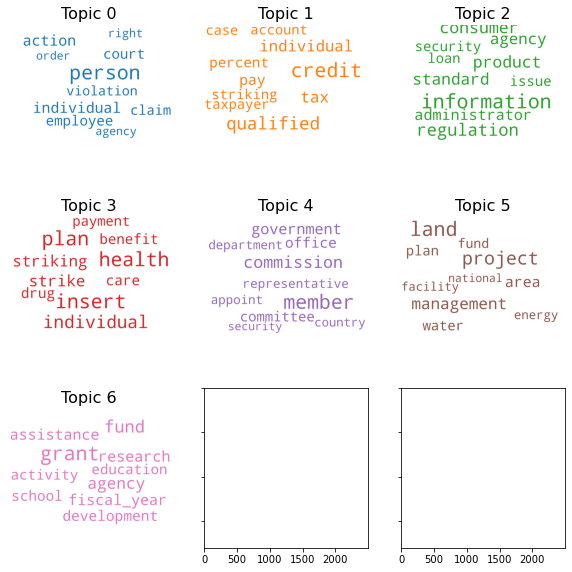

In [45]:
#  Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()